# Global Map (Climatology)

In [1]:
# --- Packages ---
## General Packages
import pandas as pd
import xarray as xr
import numpy as np
import os
import ipynbname

## GeoCAT
import geocat.comp as gccomp
import geocat.viz as gv
import geocat.viz.util as gvutil

## Visualization
import cmaps  
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom

## MatPlotLib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MultipleLocator

In [2]:
# --- Automated output filename ---
def get_filename():
    try:
        # Will fail when __file__ is undefined (e.g., in notebooks)
        filename = os.path.splitext(os.path.basename(__file__))[0]
    except NameError:
        try:
            # Will fail during non-interactive builds
            import ipynbname
            nb_path = ipynbname.path()
            filename = os.path.splitext(os.path.basename(str(nb_path)))[0]
        except Exception:
            # Fallback during Jupyter Book builds or other headless execution
            filename = "template_analysis_clim"
    return filename

fnFIG = get_filename() + ".png"
print(f"Figure filename: {fnFIG}")

Figure filename: template_analysis_clim-v02.png


In [3]:
# --- Parameter setting ---
data_dir="../data"
fname = "sst.cobe2.185001-202504.nc"
ystr, yend = 1991, 2020
fvar = "sst"

# --- Reading NetCDF Dataset ---
# Construct full path and open dataset
path_data = os.path.join(data_dir, fname)
ds = xr.open_dataset(path_data)

# Extract the variable
var = ds[fvar]

# Ensure dimensions are (time, lat, lon)
var = var.transpose("time", "lat", "lon", missing_dims="ignore")

# Ensure latitude is ascending
if var.lat.values[0] > var.lat.values[-1]:
    var = var.sortby("lat")

# Ensure time is in datetime64 format
if not np.issubdtype(var.time.dtype, np.datetime64):
    try:
        var["time"] = xr.decode_cf(ds).time
    except Exception as e:
        raise ValueError("Time conversion to datetime64 failed: " + str(e))

# === Select time range ===
dat = var.sel(time=slice(f"{ystr}-01-01", f"{yend}-12-31"))
print(dat)



<xarray.DataArray 'sst' (time: 360, lat: 180, lon: 360)> Size: 93MB
[23328000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 3kB 1991-01-01 1991-02-01 ... 2020-12-01
Attributes:
    long_name:     Monthly Means of Global Sea Surface Temperature
    valid_range:   [-5. 40.]
    units:         degC
    var_desc:      Sea Surface Temperature
    dataset:       COBE-SST2 Sea Surface Temperature
    statistic:     Mean
    parent_stat:   Individual obs
    level_desc:    Surface
    actual_range:  [-3.0000002 34.392    ]


In [4]:
# --- Climatology, Anomalies, and Standard Deviation

# Using groupby
clm1 = dat.groupby("time.month").mean(dim="time")
anm1 = dat.groupby("time.month") - clm1
std1 = anm1.groupby("time.month").std(dim="time")
print(clm1.sizes)
print(anm1.sizes)
print(std1.sizes)

  

Frozen({'month': 12, 'lat': 180, 'lon': 360})
Frozen({'time': 360, 'lat': 180, 'lon': 360})
Frozen({'month': 12, 'lat': 180, 'lon': 360})


In [5]:
# Using stack and unstack to convert from time to year x month
dat = dat.assign_coords(year=dat.time.dt.year, month=dat.time.dt.month)
dat4D = dat.set_index(time=["year", "month"]).unstack("time")
dat4D = dat4D.transpose("year", "month", "lat", "lon")
print(dat4D.sizes)

# Calculate climatology, anomaly, and standar deviations
clm2 = dat4D.mean(dim="year")
anm2 = dat4D-clm2
std2 = anm2.std(dim="year")

print(clm2.sizes)
print(anm2.sizes)
print(std2.sizes)



Frozen({'year': 30, 'month': 12, 'lat': 180, 'lon': 360})
Frozen({'month': 12, 'lat': 180, 'lon': 360})
Frozen({'year': 30, 'month': 12, 'lat': 180, 'lon': 360})
Frozen({'month': 12, 'lat': 180, 'lon': 360})


In [6]:
def plot_global_panel_OP1(ax, std_data, std_levels, titleM, titleL, color_list,
                      clm_data=None, clm_levels=None):
    """
    Plot global map of monthly standard deviation with optional climatology contours.

    Parameters
    ----------
    ax : cartopy.mpl.geoaxes.GeoAxesSubplot
        Axes to plot on.
    std_data : xarray.DataArray (month, lat, lon)
        Standard deviation data to plot with filled contours.
    std_levels : list or array-like
        Contour levels for the std_data.
    title : str
        Title above the plot panel.
    color_list : list
        Colors for the colormap.
    clm_data : xarray.DataArray (month, lat, lon), optional
        Climatology data for contour overlay.
    clm_levels : list or array-like, optional
        Contour levels for climatology.
    """

    # --- Add cyclic longitudes ---
    std_cyclic = gvutil.xr_add_cyclic_longitudes(std_data, "lon")

    # --- Plot standard deviation ---
    im = ax.contourf(
        std_cyclic["lon"],
        std_cyclic["lat"],
        std_cyclic,
        levels=std_levels,
        cmap=color_list,
        extend="both",
        transform=ccrs.PlateCarree()
    )

    # --- Plot climatology contours (optional) ---
    if clm_data is not None:
        clm_cyclic = gvutil.xr_add_cyclic_longitudes(clm_data, "lon")
        levels = clm_levels if clm_levels is not None else 10
        
        csW = ax.contour(
            clm_cyclic["lon"], clm_cyclic["lat"], clm_cyclic,
            levels=levels, colors="white", linewidths=3,
            transform=ccrs.PlateCarree()
        )
        csB = ax.contour(
            clm_cyclic["lon"], clm_cyclic["lat"], clm_cyclic,
            levels=levels, colors="black", linewidths=1,
            transform=ccrs.PlateCarree()
        )

        ax.clabel(csW, inline=1, fontsize=8, fmt="%.0f")
        ax.clabel(csB, inline=1, fontsize=8, fmt="%.0f")

    # --- Map features ---
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none', zorder=0)
    ax.coastlines(linewidth=0.5, alpha=0.6)
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    # --- Option 1 ---
    gl = ax.gridlines(draw_labels=True, linestyle='dotted', color='gray', linewidth=1, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True

    # Set major tick locations
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 30))

    # Optional: Format labels with degree symbols (default is just numbers)
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}
    gl.xformatter = mticker.FuncFormatter(lambda x, _: f"{abs(int(x))}°{'E' if x >= 0 else 'W'}")
    gl.yformatter = mticker.FuncFormatter(lambda y, _: f"{abs(int(y))}°{'N' if y >= 0 else 'S'}")

    gvutil.set_titles_and_labels(ax, maintitle=titleM, maintitlefontsize=16, lefttitle=titleL, lefttitlefontsize=14)

    return im


In [9]:
def plot_global_panel_OP2(ax, std_data, std_levels, titleM, titleL, color_list,
                      clm_data=None, clm_levels=None):
    """
    Plot global map of monthly standard deviation with optional climatology contours.

    Parameters
    ----------
    ax : cartopy.mpl.geoaxes.GeoAxesSubplot
        Axes to plot on.
    std_data : xarray.DataArray (month, lat, lon)
        Standard deviation data to plot with filled contours.
    std_levels : list or array-like
        Contour levels for the std_data.
    title : str
        Title above the plot panel.
    color_list : list
        Colors for the colormap.
    clm_data : xarray.DataArray (month, lat, lon), optional
        Climatology data for contour overlay.
    clm_levels : list or array-like, optional
        Contour levels for climatology.
    """

    # --- Add cyclic longitudes ---
    std_cyclic = gvutil.xr_add_cyclic_longitudes(std_data, "lon")

    # --- Plot standard deviation ---
    im = ax.contourf(
        std_cyclic["lon"],
        std_cyclic["lat"],
        std_cyclic,
        levels=std_levels,
        cmap=color_list,
        extend="both",
        transform=ccrs.PlateCarree()
    )

    # --- Plot climatology contours (optional) ---
    if clm_data is not None:
        clm_cyclic = gvutil.xr_add_cyclic_longitudes(clm_data, "lon")
        levels = clm_levels if clm_levels is not None else 10
        
        csW = ax.contour(
            clm_cyclic["lon"], clm_cyclic["lat"], clm_cyclic,
            levels=levels, colors="white", linewidths=3,
            transform=ccrs.PlateCarree()
        )
        csB = ax.contour(
            clm_cyclic["lon"], clm_cyclic["lat"], clm_cyclic,
            levels=levels, colors="black", linewidths=1,
            transform=ccrs.PlateCarree()
        )

        ax.clabel(csW, inline=1, fontsize=8, fmt="%.0f")
        ax.clabel(csB, inline=1, fontsize=8, fmt="%.0f")

    # --- Map features ---
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none', zorder=0)
    ax.coastlines(linewidth=0.5, alpha=0.6)
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    # --- Option 2: Manual setting ---
    # --- Set major ticks explicitly ---
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    # Custom tick labels
    ax.set_yticklabels(["90°S", "60°S", "30°S", "EQ", "30°N", "60°N", "90°N"])
    ax.set_xticklabels(["180°", "120°W", "60°W", "0°", "60°E", "120°E", ""])

    # --- Set minor tick locators ---
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(15))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(10))

    # --- Add tick marks ---
    gvutil.add_major_minor_ticks(
        ax,
        labelsize=10,
        x_minor_per_major=4,  # 15° spacing for minor if major is 60°
        y_minor_per_major=3   # 10° spacing for minor if major is 30°
    )

    # --- Customize ticks to show outward ---
    ax.tick_params(
        axis="both",
        which="both",
        direction="out",
        length=6,
        width=1,
        top=True,
        bottom=True,
        left=True,
        right=True
    )

    ax.tick_params(
        axis="both",
        which="minor",
        length=4,
        width=0.75
    )

    gvutil.set_titles_and_labels(ax, maintitle=titleM, maintitlefontsize=16, lefttitle=titleL, lefttitlefontsize=14)

    return im


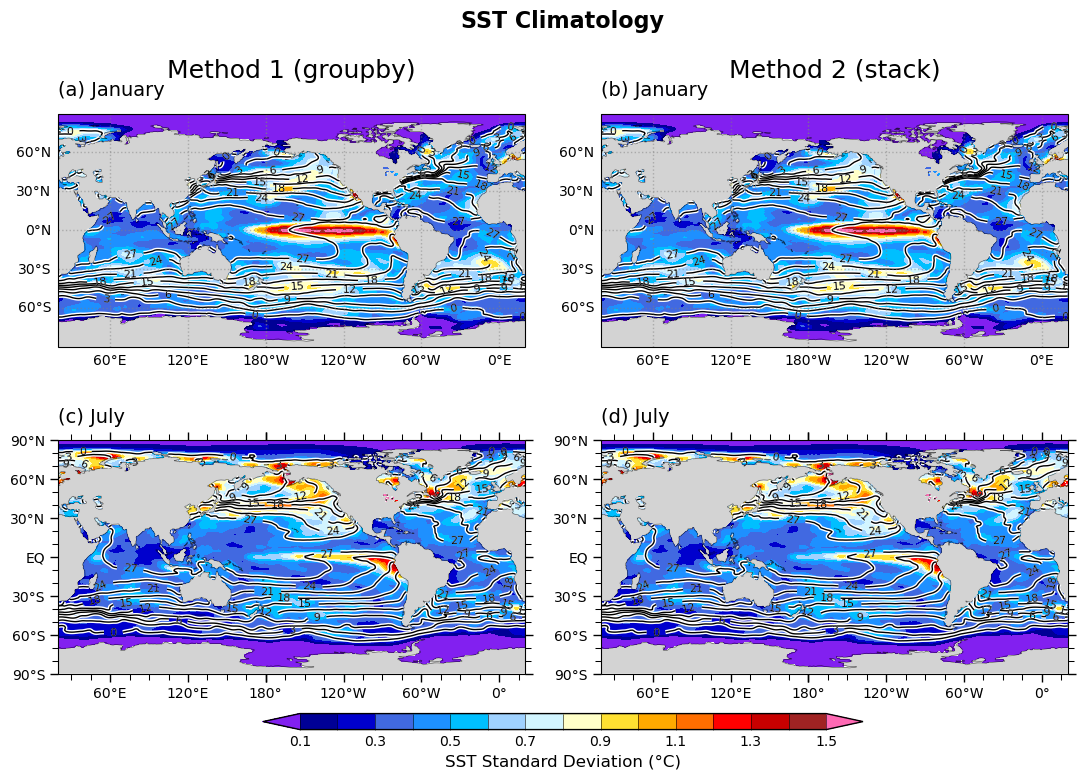

In [10]:
# --- FIGURE PLOT ---
# === Global settings ===
proj = ccrs.PlateCarree(central_longitude=200)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), subplot_kw={'projection': proj})
fig.suptitle("SST Climatology", fontsize=16, fontweight="bold")
axes = axes.flatten()  # 🔑 Make it a 1D list of axes

colormap = cmaps.amwg_blueyellowred.colors  # Use the AMWG BlueYellowRed colormap
color_list = ListedColormap(colormap[1:15])  # Use 14 colors (excluding the most extreme ends)

# Set distinct colors for under and over
color_list.set_under(colormap[0])    # Use the first color for underflow (< first level)
color_list.set_over(colormap[15])    # Use the last color for overflow (> last level)


clevs_std = np.linspace(0.1, 1.5, 15)  # 15 intervals → 16 colors
clevs_clm = np.arange(0, 36, 3)

# === Plot panels ===
imon = 1  # January
ip=0
im=plot_global_panel_OP1(axes[ip],
    std_data=std1.sel(month=imon),
    std_levels=clevs_std,
    titleM="Method 1 (groupby)",
    titleL="(a) January",
    color_list=color_list,
    clm_data=clm1.sel(month=imon),
    clm_levels=clevs_clm
)

ip=1
plot_global_panel_OP1(axes[ip],
    std_data=std2.sel(month=imon),
    std_levels=clevs_std,
    titleM="Method 2 (stack)",
    titleL="(b) January",
    color_list=color_list,
    clm_data=clm2.sel(month=imon),
    clm_levels=clevs_clm
)

imon = 7  # July
ip=2
plot_global_panel_OP2(axes[ip],
    std_data=std1.sel(month=imon),
    std_levels=clevs_std,
    titleM="",
    titleL="(c) July",
    color_list=color_list,
    clm_data=clm1.sel(month=imon),
    clm_levels=clevs_clm
)

ip=3
plot_global_panel_OP2(axes[ip],
    std_data=std2.sel(month=imon),
    std_levels=clevs_std,
    titleM="",
    titleL="(d) July",
    color_list=color_list,
    clm_data=clm2.sel(month=imon),
    clm_levels=clevs_clm
)

# --- Colorbar for im1 ---
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
cbar = plt.colorbar(im, cax=cbar_ax, orientation="horizontal",
                    spacing="uniform", extend='both',
                    extendfrac=0.07,  # 🔑 Make the edge triangles slightly larger
                    drawedges=True)
cbar.set_label("SST Standard Deviation (°C)", fontsize=12)
cbar.ax.tick_params(length=0, labelsize=10)
cbar.outline.set_edgecolor("black")
cbar.outline.set_linewidth(1.0)


# === Finalize ===
#plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.01, left=0.05, right=0.95, top=0.85, bottom=0.15)
plt.savefig(fnFIG, dpi=300, bbox_inches="tight")
plt.show()

